### Importing libraries

In [1]:
# required libraries
import time
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

### Getting data prepared for the model

In [2]:
# function to get and process data for one day
def process_data_for_model(file_name):
    # start time
    startTime = time.time()
    
    # data for one day
    column_names = ['Time','Duration','SrcDevice','DstDevice','Protocol','SrcPort','DstPort','SrcPackets','DstPackets','SrcBytes','DstBytes']
    day = pd.read_csv(file_name, header = None)
    day.columns = column_names
    print('File read in successfully.')
    
    # keeping only the last row of the same transaction since connections are cumulative
    five_tuple = ['Time', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort']
    day = day.drop_duplicates(subset = five_tuple, keep = 'last')
    print('Dropped duplicates.')
    
    # removing characters from port numbers
    day['SrcPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
    day['DstPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
    
    # convert to numeric for binning later
    day['SrcPort'] = day['SrcPort'].astype(int)
    day['DstPort'] = day['DstPort'].astype(int)
    print('Removed non-digits from SrcPort and DstPort.')
    
    # removing digits from 'SrcDevice' and 'DestDevice'
    day['SrcDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
    day['DstDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
    print('Removed digits from SrcDevice and DstDevice.')
    
    # replace 'Time' column with hour intervals
    start_time = day['Time'].min()
    end_time = day['Time'].max()
    hour_bins = np.arange(start_time - 1, end_time + 2, step = 3600)
    day['Time'] = np.searchsorted(hour_bins, day['Time'].values)
    print('Time column binned into hourly intervals.')
    
    # bin source and destination port numbers into categories
    # 3 categories for now...0-1023, 1024-49151, 49152-65535...
    port_bins = [-1, 1023, 49151]
    day['SrcPort'] = np.searchsorted(port_bins, day['SrcPort'].values)
    day['DstPort'] = np.searchsorted(port_bins, day['DstPort'].values)
    print('SrcPort and DstPort put into bins.')
    
    # converting 'Time', 'Protocol', 'SrcPort' and 'DstPort' to categorical variables for model
    day['Time'] = day['Time'].astype('category')
    day['Protocol'] = day['Protocol'].astype('category')
    day['SrcPort'] = day['SrcPort'].astype('category')
    day['DstPort'] = day['DstPort'].astype('category')
    
    # converting to categorical reduces time while label encoding
    day['SrcDevice'] = day['SrcDevice'].astype('category')
    day['DstDevice'] = day['DstDevice'].astype('category')
    
    # converting character variables to encodings
    day['SrcDevice'] = day['SrcDevice'].cat.codes
    day['DstDevice'] = day['DstDevice'].cat.codes
    
    # converting them back to categorical since encoding makes them numeric
    day['SrcDevice'] = day['SrcDevice'].astype('category')
    day['DstDevice'] = day['DstDevice'].astype('category')
    print('Categorical variables encoded and dtype changed to category.')
    
    # log transforming numerical variables
    day['SrcBytes'] = np.log(day['SrcBytes'] + 0.001)
    day['DstBytes'] = np.log(day['DstBytes'] + 0.001)
    day['SrcPackets'] = np.log(day['SrcPackets'] + 0.001)
    day['DstPackets'] = np.log(day['DstPackets'] + 0.001)
    day['Duration'] = np.log(day['Duration'] + 0.001)
    print('Log transformation done.')
    
    # print time taken for execution
    time_taken_in_seconds = time.time() - startTime
    print('Time taken:', time_taken_in_seconds/60, 'minutes,', time_taken_in_seconds//60, 'seconds.')
    
    # return processed dataset
    return day

In [3]:
# file names from day 03-09
file_names = ['netflow_day-03', 'netflow_day-04', 'netflow_day-05', 'netflow_day-06', 'netflow_day-07', 'netflow_day-08', 'netflow_day-09']

# get data for day03
data = process_data_for_model(file_names[0])

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 29.154321599006654 minutes, 29.0 seconds.


In [10]:
data.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
170337554,20,-6.907755,1,0,6,2,2,1.098946,-6.907755,4.969820,-6.907755
69138870,9,-6.907755,1,1,6,3,3,2.833272,2.639129,8.070281,8.359604
88722256,11,-6.907755,1,1,6,3,3,-6.907755,0.001000,-6.907755,3.828663
136295764,16,-6.907755,1,1,6,3,3,0.001000,0.001000,4.094361,3.828663
4895931,1,0.001000,1,1,6,2,1,-6.907755,1.386544,-6.907755,6.204560


### Model building

In [5]:
sample_size = 10000000

# taking a representative sample 
data = data.sample(n = sample_size)

In [7]:
day4 = process_data_for_model(file_names[1])
day4 = day4.sample(n = sample_size)

In [8]:
day4.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
171681835,19,0.001000,1,1,6,2,1,-6.907755,2.565026,-6.907755,9.449121
99176741,13,-6.907755,1,1,17,3,1,-6.907755,0.001000,-6.907755,6.095827
201621067,22,-6.907755,1,0,6,2,1,1.946053,-6.907755,7.670429,-6.907755
86797230,12,8.853094,1,1,1,2,2,7.351801,-6.907755,11.180441,-6.907755
18330764,3,-6.907755,1,1,17,2,1,0.001000,-6.907755,4.158899,-6.907755


In [11]:
day5 = process_data_for_model(file_names[2])
day5 = day5.sample(n = sample_size)

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 29.08482349316279 minutes, 29.0 seconds.


In [12]:
day5.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
13826636,2,-6.907755,1,1,17,2,1,0.001000,-6.907755,4.204708,-6.907755
167170205,19,-6.907755,1,1,6,2,3,1.386544,0.693647,5.375283,4.718508
112951083,13,0.001000,1,1,17,2,1,0.001000,-6.907755,4.204708,-6.907755
176774688,21,0.001000,1,1,6,3,2,1.609638,1.609638,5.624021,7.315219
145887149,16,6.120300,1,1,6,2,2,2.397986,2.397986,7.122061,7.385852


In [13]:
day6 = process_data_for_model(file_names[3])
day6 = day6.sample(n = sample_size)

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 25.309383539358773 minutes, 25.0 seconds.


In [14]:
day6.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
9687445,2,-6.907755,1,1,17,3,1,0.001000,-6.907755,4.317501,-6.907755
114185319,16,-6.907755,1,1,6,3,2,0.001000,0.001000,3.951263,3.828663
86827377,12,0.001000,1,2,6,3,2,1.386544,1.098946,5.375283,5.099873
78136457,10,-6.907755,1,1,6,3,1,1.098946,0.693647,5.099873,4.663449
173276948,24,2.197336,1,1,6,2,2,1.098946,-6.907755,5.023887,-6.907755


In [15]:
day7 = process_data_for_model(file_names[4])
day7 = day7.sample(n = sample_size)

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 26.441957279046377 minutes, 26.0 seconds.


In [16]:
day7.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
114896722,17,0.001000,1,2,6,2,2,-6.907755,0.693647,-6.907755,6.403576
88616304,13,0.001000,1,1,6,2,3,2.397986,2.302685,6.378428,9.150697
89099461,13,0.001000,1,0,6,2,1,0.001000,-6.907755,4.158899,-6.907755
83507080,12,0.001000,1,1,6,2,1,1.098946,-6.907755,5.023887,-6.907755
145226559,20,-6.907755,1,1,17,2,1,0.001000,-6.907755,4.369461,-6.907755


In [17]:
day8 = process_data_for_model(file_names[5])
day8 = day8.sample(n = sample_size)

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 31.032951128482818 minutes, 31.0 seconds.


In [18]:
day8.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
10135459,2,0.001000,1,1,6,2,2,-6.907755,0.001000,-6.907755,3.828663
25521322,4,-6.907755,1,1,6,2,3,-6.907755,0.001000,-6.907755,3.828663
31684038,5,0.001000,1,2,6,2,1,1.609638,1.098946,5.624021,6.748761
147739456,16,0.001000,1,1,6,3,2,-6.907755,0.001000,-6.907755,3.828663
67150755,8,0.001000,1,1,6,3,1,2.397986,-6.907755,7.536364,-6.907755


In [19]:
day9 = process_data_for_model(file_names[6])
day9 = day9.sample(n = sample_size)

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 30.468664820988973 minutes, 30.0 seconds.


In [20]:
day9.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
181843598,21,-6.907755,1,1,6,2,1,1.609638,-6.907755,6.617404,-6.907755
151110034,17,0.001000,1,1,6,3,3,1.386544,1.098946,5.347112,5.105952
56727320,7,0.001000,1,1,17,2,1,-6.907755,0.001000,-6.907755,5.846442
149007295,17,0.001000,1,1,17,3,1,1.946053,-6.907755,8.844481,-6.907755
72872371,9,0.001000,1,1,6,2,1,-6.907755,1.791926,-6.907755,6.584793


In [21]:
one_week = pd.concat([data, day4, day5, day6, day7, day8, day9], ignore_index = True, axis = 0)
del [data, day4, day5, day6, day7, day8, day9]
one_week = one_week.sample(n = sample_size)
one_week.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
27555392,5,-6.907755,1,1,6,3,2,0.001000,0.001000,4.094361,3.828663
45326613,4,-6.907755,1,1,6,2,2,-6.907755,0.001000,-6.907755,3.828663
19987429,2,-6.907755,1,1,17,2,1,0.001000,-6.907755,6.356109,-6.907755
6740515,17,-6.907755,1,1,6,2,1,1.609638,-6.907755,5.988964,-6.907755
53806666,12,0.001000,1,1,6,3,1,2.302685,2.397986,6.804616,6.658012


In [23]:
# isolation forest model
clf = IsolationForest(n_estimators = 100, max_samples = 100000, contamination = 0.01)
clf.fit(one_week)
predictions = clf.predict(one_week)

# raw scores
isolation_scores = clf.decision_function(one_week)

In [24]:
# checking percentage of anomalies
unique, counts = np.unique(predictions, return_counts = True)
dict(zip(unique, counts))

{-1: 100000, 1: 9900000}

Distribution of isolation scores:

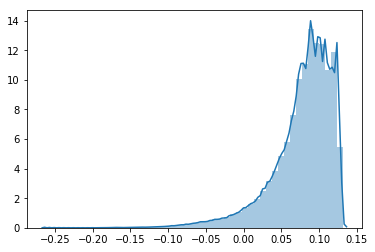

In [25]:
plot = sns.distplot(isolation_scores)

### Visualization

Processing data for PCA:

In [27]:
# one hot encoding and scaling data for PCA
categorical = one_week.columns[one_week.dtypes == 'category'].values
numeric = one_week.columns[one_week.dtypes != 'category'].values
data_for_dim_red = pd.get_dummies(one_week[categorical]).merge(one_week[numeric], left_index = True, right_index = True)
data_for_dim_red = StandardScaler().fit_transform(data_for_dim_red)

2D PCA:

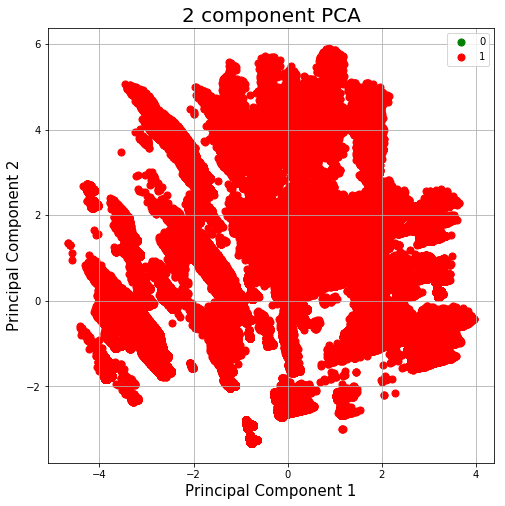

In [28]:
# PCA for 2 components
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(data_for_dim_red)
principalComponents = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalComponents['Predictions'] = predictions

# plotting the components
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalComponents['Predictions'] == target
    ax.scatter(principalComponents.loc[indicesToKeep, 'PC1']
               , principalComponents.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

3D PCA:

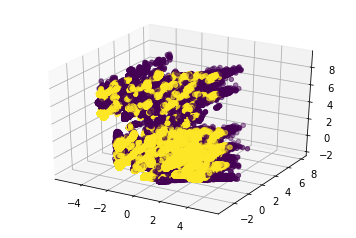

In [29]:
# PCA for 3 components
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(data_for_dim_red)
principalComponents = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
principalComponents['Predictions'] = predictions

# plotting components
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(principalComponents['PC1'], principalComponents['PC2'], principalComponents['PC3'], 
             c = principalComponents['Predictions'], cmap = 'viridis');

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsneComponents = tsne.fit_transform(data_for_dim_red)